In [ ]:
!pip install pytorch_model_summary

In [ ]:

import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as Acivation
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from pytorch_model_summary import summary
import torch.nn.functional as F

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/work1/tdata.zip', 'r')
file = zip_ref.extractall("./tmp")
zip_ref.close()

print("o")

o


In [ ]:
DATASET="/content/tmp/tdata/train"
DATASET2="/content/tmp/tdata/valid"

In [ ]:
CATEGORIES=["Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___healthy","Tomato___Late_blight","Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot","Tomato___Tomato_mosaic_virus","Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
        
train_data=[]

In [ ]:
import os
import tensorflow as tf

import cv2
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))            
            train_data.append([img,label])
            
test_data=[]

In [ ]:
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET2,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))
            test_data.append([img,label])
            
print(len(train_data))
print(len(test_data))

18345
4585


In [ ]:
random.shuffle(train_data)
random.shuffle(test_data)

In [ ]:
for lbl in train_data[:10]:
    print(lbl[1])
    
X_train=[]
y_train=[]

1
3
2
9
5
3
1
5
1
5


In [ ]:
for features,label in train_data:
    X_train.append(features)
    y_train.append(label)

In [ ]:
Y=[]
for i in y_train:
    if i==0:
        Y.append("BACTERIAL SPOT")
    elif i==1:
        Y.append("EARLY BLIGHT")
    elif i==2:
        Y.append("HEALTHY")
    elif i==3:
        Y.append("LATE BLIGHT")
    elif i==4:
        Y.append("LEAF MOLD")
    elif i==5:
        Y.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Y.append("SPIDER MITE")
    elif i==7:
        Y.append("TARGET SPOT")
    elif i==8:
        Y.append("MOSAIC VIRUS")
    else:
        Y.append("YELLOW LEAF CURL VIRUS")

In [ ]:
len(X_train),len(y_train)

(18345, 18345)

In [ ]:
X_test=[]
y_test=[]

In [ ]:
for features,label in test_data:
    X_test.append(features)
    y_test.append(label)
    
Z=[]
for i in y_test:
    if i==0:
        Z.append("BACTERIAL SPOT")
    elif i==1:
        Z.append("EARLY BLIGHT")
    elif i==2:
        Z.append("HEALTHY")
    elif i==3:
        Z.append("LATE BLIGHT")
    elif i==4:
        Z.append("LEAF MOLD")
    elif i==5:
        Z.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Z.append("SPIDER MITE")
    elif i==7:
        Z.append("TARGET SPOT")
    elif i==8:
        Z.append("MOSAIC VIRUS")
    else:
        Z.append("YELLOW LEAF CURL VIRUS")

In [ ]:
len(X_test),len(y_test)

(4585, 4585)

In [ ]:
import numpy as np
X_train=np.array(X_train).reshape(-1, 224,224,3)
X_train.shape

(18345, 224, 224, 3)

In [ ]:
X_test=np.array(X_test).reshape(-1, 224,224,3)
X_test.shape

(4585, 224, 224, 3)

In [ ]:
y_train[:2], y_test[:2]

([1, 3], [9, 9])

In [ ]:
X_test.shape

(4585, 224, 224, 3)

In [ ]:
class TOMATO_DATASET(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x_batch = self.x[index]
        y_batch = self.y[index]

        if self.transform is not None:
            x_batch = self.transform(x_batch)
        
        y_batch = torch.from_numpy(np.array(y_batch))

        return x_batch, y_batch


In [ ]:

transform1 = transforms.Compose([
    #transforms.Resize(224, 224),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, ), (0.5, ) )
])


train_dataset = TOMATO_DATASET(X_train, y_train, transform=transform1)
valid_dataset = TOMATO_DATASET(X_test, y_test, transform=transform1)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)



dataiter = iter(valid_loader)
images, label = dataiter.next()

print(images.shape, label.shape)


torch.Size([100, 3, 224, 224]) torch.Size([100])


In [ ]:
class CNN(nn.Module):

    def __init__(self,vgg_features):
        super().__init__()

        self.features = vgg_features

    def forward(self, z):
        z = self.features(z)
        z = z.view(-1, 512*7*7)

        return z


class CNN_LSTM(nn.Module):

    def __init__(self, vgg_features):
        super(CNN_LSTM, self).__init__()
        self.cnn = CNN(vgg_features)
        self.rnn = nn.LSTM(
            input_size=512*7*7, 
            hidden_size=64, 
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.linear = nn.Linear(128,10)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)

In [ ]:
vgg_f =  models.vgg16(pretrained=True).features
model_cnn = CNN(vgg_f)

# show output shape
print(summary(model_cnn, torch.zeros((1, 3, 224, 224)), show_input=False))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



--------------------------------------------------------------------------
      Layer (type)           Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 64, 224, 224]           1,792           1,792
            ReLU-2      [1, 64, 224, 224]               0               0
          Conv2d-3      [1, 64, 224, 224]          36,928          36,928
            ReLU-4      [1, 64, 224, 224]               0               0
       MaxPool2d-5      [1, 64, 112, 112]               0               0
          Conv2d-6     [1, 128, 112, 112]          73,856          73,856
            ReLU-7     [1, 128, 112, 112]               0               0
          Conv2d-8     [1, 128, 112, 112]         147,584         147,584
            ReLU-9     [1, 128, 112, 112]               0               0
      MaxPool2d-10       [1, 128, 56, 56]               0               0
         Conv2d-11       [1, 256, 56, 56]         295,168         295,168
           ReLU-12       [1, 256, 56

In [ ]:
vgg_f =  models.vgg16(pretrained=True).features
model_cnn_lstm = CNN_LSTM(vgg_f)

# show output shape
print(summary(model_cnn_lstm, torch.zeros((1,1, 3, 224, 224)), show_input=False))

-------------------------------------------------------------------------------------------
      Layer (type)                            Output Shape         Param #     Tr. Param #
             CNN-1                              [1, 25088]      14,714,688      14,714,688
            LSTM-2     [1, 1, 128], [2, 1, 64], [2, 1, 64]      12,878,848      12,878,848
          Linear-3                                 [1, 10]           1,290           1,290
Total params: 27,594,826
Trainable params: 27,594,826
Non-trainable params: 0
-------------------------------------------------------------------------------------------


In [ ]:
model = model_cnn_lstm.to(device)

In [ ]:

# loss function and optimizer
model_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training
loss_history = []
acc_history =  []
val_acc_history = []
val_loss_history = []
EPOCHS = 20

for e in range(EPOCHS):
    batch_loss = 0.0
    batch_acc = 0.0

    val_batch_loss = 0.0
    val_batch_acc = 0.0

    i = 0
    for x_bacth, y_batch in train_loader:
        i = i + 1
        optimizer.zero_grad() # set gradient to zero

        # print(x_train.shape)
        x_train = x_bacth.to(device) #x_bacth.view(x_bacth.shape[0], -1)
        x_train = x_train.view(x_train.shape[0], 1,x_train.shape[1], x_train.shape[2], x_train.shape[3])
        y_batch = y_batch.to(device)
        y_pred = model.forward(x_train)
        # loss = model_loss(y_pred, y_batch)

        loss = F.nll_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(y_pred, 1)
        batch_loss = batch_loss + loss / len(train_loader)
        batch_acc = batch_acc + torch.sum(preds == y_batch.data) / ( len(train_loader) * 100 )

        print('Epoch: {} & Iteration: {} ~ = batch_loss: {:.4f}, batch_acc: {:.4f}'.format(e+1,i, batch_loss, batch_acc.item()))

    with torch.no_grad():
        i = 0
        for x_val, y_val in valid_loader:
            i = i+1
            # x_val =  x_val.view(x_val.shape[0], -1)
            x_val = x_val.to(device) #x_bacth.view(x_bacth.shape[0], -1)
            x_val = x_val.view(x_val.shape[0], 1,x_val.shape[1], x_val.shape[2], x_val.shape[3])
            y_val = y_val.to(device)

            y_pred = model.forward(x_val)
            val_loss = model_loss(y_pred, y_val)

            _, preds = torch.max(y_pred, 1)
            val_batch_loss = val_batch_loss + val_loss / len(valid_loader)
            val_batch_acc = val_batch_acc + torch.sum(preds == y_val.data) / (len(valid_loader) * 100)

            print('Epoch: {} & Iteration: {} ~ = val batch_loss: {:.4f}, val batch_acc: {:.4f}'.format(e+1,i, val_batch_loss, val_batch_acc.item()))




    epoch_loss = batch_loss
    epoch_acc = batch_acc.float()
    val_epoch_loss = val_batch_loss
    val_epoch_acc = val_batch_acc.float()

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    val_acc_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)
    print('Epoch: {},~ = training_loss: {:.4f}, training_acc: {:.4f}; val_loss: {:.4f}, val_acc: {:.4f}'.format(e+1, epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))


Epoch: 1 & Iteration: 1 ~ = batch_loss: 0.0128, batch_acc: 0.0003
Epoch: 1 & Iteration: 2 ~ = batch_loss: 0.0255, batch_acc: 0.0008
Epoch: 1 & Iteration: 3 ~ = batch_loss: 0.0379, batch_acc: 0.0015
Epoch: 1 & Iteration: 4 ~ = batch_loss: 0.0503, batch_acc: 0.0023
Epoch: 1 & Iteration: 5 ~ = batch_loss: 0.0627, batch_acc: 0.0032
Epoch: 1 & Iteration: 6 ~ = batch_loss: 0.0750, batch_acc: 0.0043
Epoch: 1 & Iteration: 7 ~ = batch_loss: 0.0873, batch_acc: 0.0054
Epoch: 1 & Iteration: 8 ~ = batch_loss: 0.0996, batch_acc: 0.0063
Epoch: 1 & Iteration: 9 ~ = batch_loss: 0.1119, batch_acc: 0.0072
Epoch: 1 & Iteration: 10 ~ = batch_loss: 0.1242, batch_acc: 0.0083
Epoch: 1 & Iteration: 11 ~ = batch_loss: 0.1365, batch_acc: 0.0092
Epoch: 1 & Iteration: 12 ~ = batch_loss: 0.1488, batch_acc: 0.0101
Epoch: 1 & Iteration: 13 ~ = batch_loss: 0.1612, batch_acc: 0.0107
Epoch: 1 & Iteration: 14 ~ = batch_loss: 0.1731, batch_acc: 0.0119
Epoch: 1 & Iteration: 15 ~ = batch_loss: 0.1853, batch_acc: 0.0128
Epoc

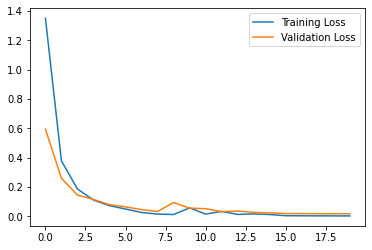

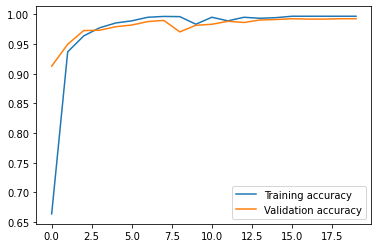

In [ ]:
import matplotlib.pyplot as plt


plt.plot(loss_history,label='Training Loss')  
plt.plot(val_loss_history,label='Validation Loss')  
plt.legend()  
plt.show()  
plt.plot(acc_history,label='Training accuracy')  
plt.plot(val_acc_history,label='Validation accuracy')  
plt.legend()  
plt.show()  

In [ ]:
PATH = '/content/drive/MyDrive/work2/bimodel_weights_lstm.pth'
torch.save(model, PATH)